In [1]:
import sys
sys.path.append('..')
sys.path.append('../stylegan3')

import pickle

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np

from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

from pytorch_nn_r import TorchRegressionTraining

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [2]:
class MovingLatentA(nn.Module):
    def __init__(self, n_features):
        super().__init__()

        self.name = 'moving_latent_a'
        self.shifter = nn.Sequential(
            nn.Linear(512+n_features, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512))            
        
    def forward(self, x, features):
        return self.shifter(torch.cat((features, x), dim=1))

In [8]:
class MovingLatentB(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        
        self.name = 'moving_latent_b'
        self.shifter = nn.Sequential(
            nn.Linear(512+n_features, 256),
            nn.ReLU(),
            nn.Linear(256, 512))            
        
    def forward(self, x, features):
        return self.shifter(torch.cat((features, x), dim=1))

In [10]:
class MovingLatentC(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        
        self.name = 'moving_latent_c'
        self.shifter = nn.Sequential(
            nn.Linear(512+n_features, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512))            
        
    def forward(self, x, features):
        return self.shifter(torch.cat((features, x), dim=1))

In [11]:
class MovingLatentD(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        
        self.name = 'moving_latent_d'
        self.shifter = nn.Sequential(
            nn.Linear(512+n_features, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512))            
        
    def forward(self, x, features):
        return self.shifter(torch.cat((features, x), dim=1))

In [12]:
class MovingLatentE(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        
        self.name = 'moving_latent_e'
        self.shifter = nn.Sequential(
            nn.Linear(512+n_features, 1024),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.Linear(1024,1024),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.Linear(1024,1024),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.Linear(1024, 512))            
        
    def forward(self, x, features):
        return self.shifter(torch.cat((features, x), dim=1))

In [6]:
feature = 'eyeglasses'

batch_size = 64
num_epochs = 10
learning_rate = 1e-5

pkl_path = '/home/robert/data/diploma-thesis/datasets/features/'+feature+'_dataset.pkl'

model = MovingLatentA(1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

save_filename = model.name + '_' + feature + '.pt'

experiment = Experiment(
  api_key = "MqskAFE0NPXT89J9t3bXaz6ac",
  project_name = "pytorch-moving-latent",
  workspace="wicwik"
)

hyper_params = {
'learning_rate': learning_rate,
'batch_size': batch_size,
'loss': 'MSELoss',
'optimizer': "Adam",
'save_filename': save_filename,
'n_parameters': count_parameters(model),
'feature': feature,
}

experiment.set_name(model.name + '_' + feature)
experiment.log_parameters(hyper_params)

log_model(experiment, model, model_name=model.name)
experiment.set_model_graph(model, overwrite=False)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/wicwik/pytorch-moving-latent/ab8076b6a2b84474b1b150a1bdf0c595



In [7]:
trainer = TorchRegressionTraining(model=model, pkl_path=pkl_path, loss_fn=criterion, optimizer=optimizer, batch_size=batch_size, save_filename=save_filename, experiment=experiment)
trainer.run_training(epochs=num_epochs)

cuda
Filename: /home/robert/diploma-thesis/DP/notebooks/../pytorch_nn_r.py

Line #    Mem usage    Increment  Occurences   Line Contents
    37   6027.3 MiB   6027.3 MiB           1       @profile
    38                                             def __init__(self, model, pkl_path, loss_fn, optimizer, batch_size, save_filename = None, experiment = None):
    39   6027.3 MiB      0.0 MiB           1           self._set_device()
    40   6027.3 MiB      0.0 MiB           1           print(self.__device)
    41                                         
    42   6665.5 MiB      0.0 MiB           2           with open(pkl_path, 'rb') as f:
    43   6665.5 MiB    638.2 MiB           1               data = pickle.load(f)
    44                                         
    45   6759.9 MiB     94.3 MiB           1           dataset = TensorDataset(torch.Tensor(np.stack(data[:, 0])), torch.Tensor(np.stack(data[:, 1])), torch.Tensor(np.stack(data[:, 2])))
    46                                   

In [8]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/wicwik/pytorch-moving-latent/ab8076b6a2b84474b1b150a1bdf0c595
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     avg_test_loss_per_epoch       : 0.021437987342758483
COMET INFO:     avg_test_mae_per_epoch        : 0.09116058287137153
COMET INFO:     avg_test_r2_per_epoch         : 0.97780241855641
COMET INFO:     avg_train_loss_per_epoch [10] : (0.022818406547509856, 0.8103650118843202)
COMET INFO:     avg_train_mae_per_epoch [10]  : (0.09584570411071983, 0.7158999005056197)
COMET INFO:     avg_train_r2_per_epoch [10]   : (0.1733881332123682, 0.9763903474935921)
COMET INFO:     avg_valid_loss_per_epoch [10] : (0.021185284

In [3]:
model_eyeglasses = MovingLatentA(1).cuda()
save_filename = 'moving_latent_a_eyeglasses.pt'
model_eyeglasses.load_state_dict(torch.load(save_filename))

model_male = MovingLatentA(1).cuda()
save_filename = 'moving_latent_a_male.pt'
model_male.load_state_dict(torch.load(save_filename))

model_black_hair = MovingLatentA(1).cuda()
save_filename = 'moving_latent_a_black_hair.pt'
model_black_hair.load_state_dict(torch.load(save_filename))

<All keys matched successfully>

In [4]:
model = model_male

In [5]:
rnd = np.random.RandomState(123)
latents = rnd.randn(9, 512)

In [6]:
model.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()
    labels = torch.ones(len(x),1).cuda()
    print(labels)
    shifted = model(x, labels).cpu().numpy()

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')


In [7]:
from stylegan_generator import StyleGANGenerator
network_pkl = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-1024x1024.pkl'
generator = StyleGANGenerator(network_pkl)

In [9]:
imgs1 = generator.generate_from(latents, truncation_psi=0.7)
imgs2 = generator.generate_from(shifted, truncation_psi=0.7)

In [10]:
import matplotlib.pyplot as plt

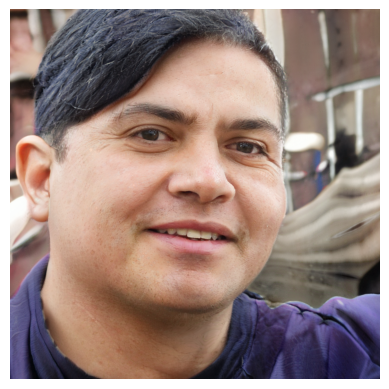

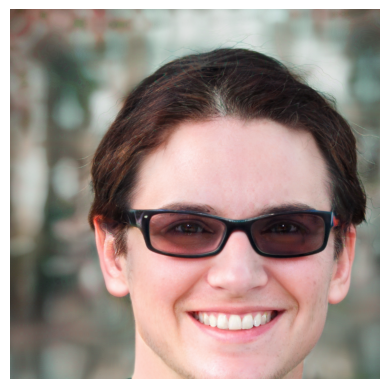

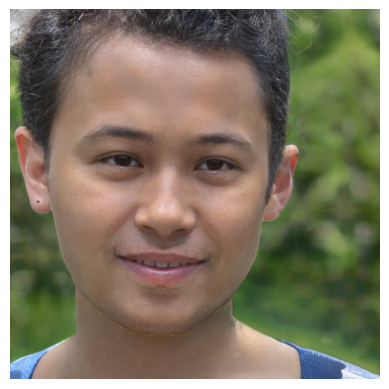

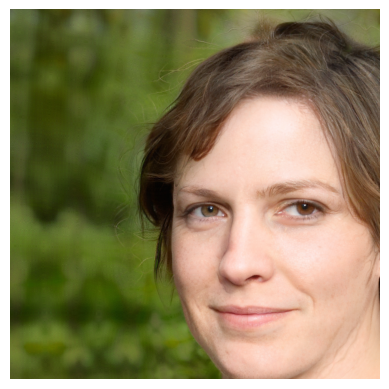

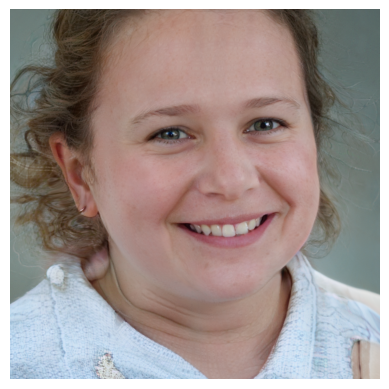

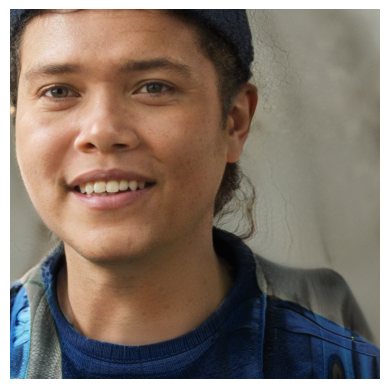

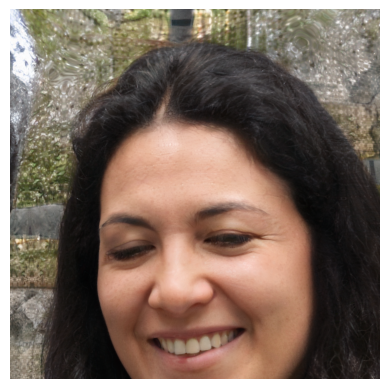

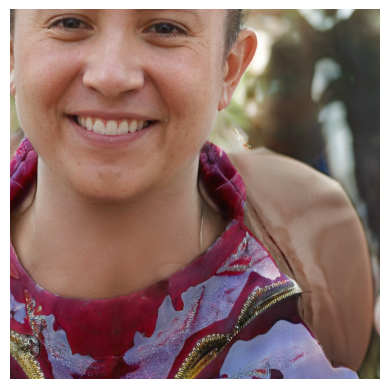

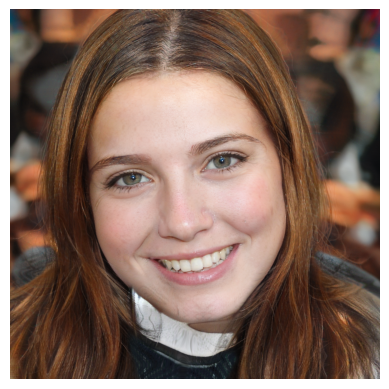

In [11]:
for i, img in enumerate(imgs1):
    plt.axis("off")
    plt.imshow(img/255)
    plt.savefig(f'img_orig_{i}.png')
    plt.show()

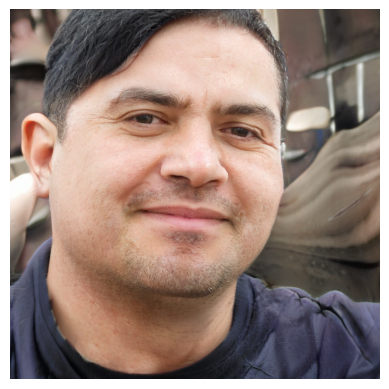

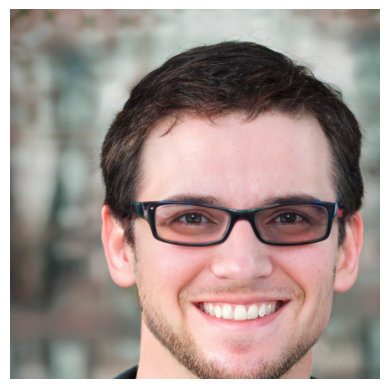

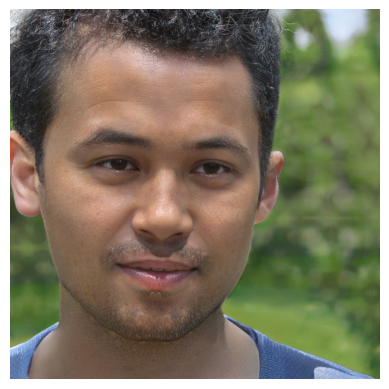

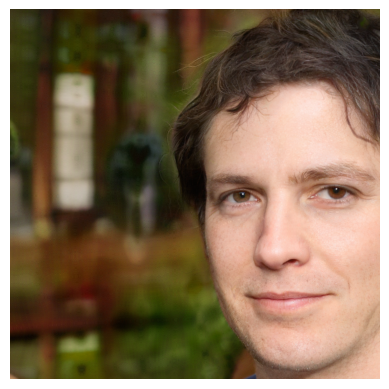

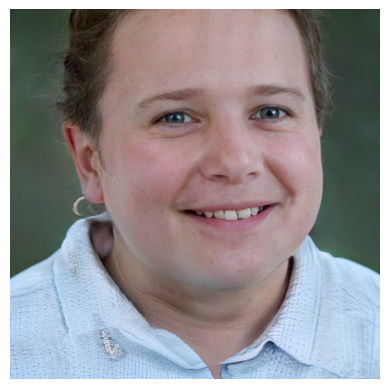

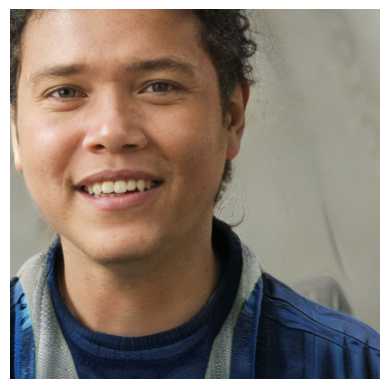

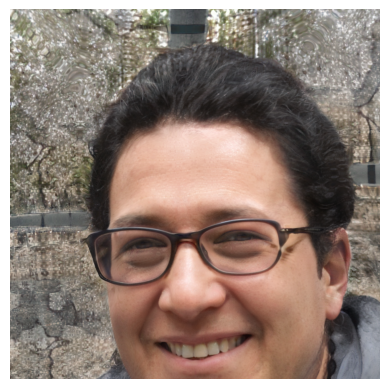

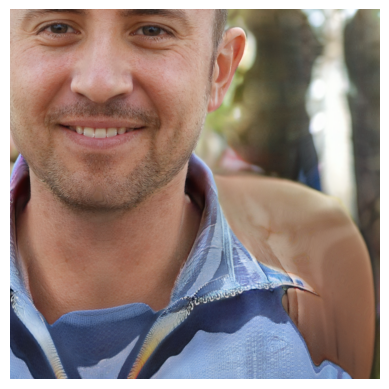

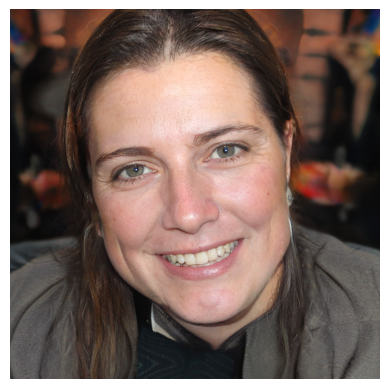

In [12]:
for i, img in enumerate(imgs2):
    plt.axis("off")
    plt.imshow(img/255)
    plt.savefig(f'img_shifted_{i}.png')
    plt.show()

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
model = MovingLatentA(1)
print(model.name, count_parameters(model))

model = MovingLatentB(1)
print(model.name, count_parameters(model))

model = MovingLatentC(1)
print(model.name, count_parameters(model))

model = MovingLatentD(1)
print(model.name, count_parameters(model))

model = MovingLatentE(1)
print(model.name, count_parameters(model))

moving_latent_a 1051136
moving_latent_b 263168
moving_latent_c 5248512
moving_latent_d 329088
moving_latent_e 3150336
